In [59]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
import json

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2]:
#extracting latest weather
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
	"latitude": [5.390770,5.392571,5.324686,5.323670],
	"longitude": [-6.505318,-6.427247, -6.502779,-6.427451],
	"start_date": "1940-01-01",
	"end_date": "2023-12-31",
	"daily": ["weather_code","temperature_2m_max", "temperature_2m_min","temperature_2m_mean", "precipitation_sum", "rain_sum"],
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

In [3]:
# Processing locations into a list
def gps_location_to_weather(api_response):
    actual_weather =[]
    for i in range(len(params["latitude"])):
        response = responses[i]
        print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
        print(f"Elevation {response.Elevation()} m asl")
        print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
        print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
        # Process daily data. The order of variables needs to be the same as requested.
        daily = response.Daily()
        daily_weather_code = daily.Variables(0).ValuesAsNumpy()
        daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
        daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
        daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
        daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
        daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
        
        daily_data = {"date": pd.date_range(
        	start = pd.to_datetime(daily.Time(), unit = "s"),
        	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
        	freq = pd.Timedelta(seconds = daily.Interval()),
        	inclusive = "left"
        )}
        daily_data["weather_code"] = daily_weather_code
        daily_data["temperature_2m_max"] = daily_temperature_2m_max
        daily_data["temperature_2m_min"] = daily_temperature_2m_min
        daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
        daily_data["precipitation_sum"] = daily_precipitation_sum
        daily_data["rain_sum"] = daily_rain_sum
    
        actual_weather.append(daily_data)

    return actual_weather

In [4]:
cocoa = gps_location_to_weather(responses)

Coordinates 5.3778557777404785°E -6.481781005859375°N
Elevation 109.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.3778557777404785°E -6.40728759765625°N
Elevation 82.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.307557106018066°E -6.4764404296875°N
Elevation 97.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.307557106018066°E -6.4019775390625°N
Elevation 97.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [5]:
cocoa

[{'date': DatetimeIndex(['1940-01-01', '1940-01-02', '1940-01-03', '1940-01-04',
                 '1940-01-05', '1940-01-06', '1940-01-07', '1940-01-08',
                 '1940-01-09', '1940-01-10',
                 ...
                 '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
                 '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
                 '2023-12-30', '2023-12-31'],
                dtype='datetime64[ns]', length=30681, freq='D'),
  'weather_code': array([63., 61., 53., ..., 51., 51., 51.], dtype=float32),
  'temperature_2m_max': array([28.087   , 28.237   , 27.337   , ..., 35.424   , 33.823997,
         35.724   ], dtype=float32),
  'temperature_2m_min': array([21.036999, 21.337   , 20.487   , ..., 23.124   , 23.924002,
         23.424002], dtype=float32),
  'temperature_2m_mean': array([23.436998, 23.43492 , 22.797417, ..., 27.99275 , 27.77817 ,
         28.05525 ], dtype=float32),
  'precipitation_sum': array([nan, 5.3, 0.7, ..., 0.3, 0.5, 0

In [6]:
#defining the weights list for all location
locations_weights = [1/len(cocoa) for i in range(len(cocoa))]
locations_weights

[0.25, 0.25, 0.25, 0.25]

In [7]:
#Building a country climatology from all gps locations
def climatology_build(weather_per_location):

    country_weather = pd.DataFrame()
    for locations in range(len(weather_per_location)):
        weather_point = pd.DataFrame(weather_per_location[locations])
        
        #adding year column and month_number column
        weather_point['month_number'] = weather_point['date'].dt.month
        weather_point['year'] = weather_point['date'].dt.year
        
        #creating rain_season rainfall, dry_season rainfall and total rainfall per year
        weather_grouped = weather_point.groupby(['year', weather_point['month_number'].isin([5, 6, 7, 8, 9])])['precipitation_sum'].sum().unstack(fill_value=0)
        weather_grouped.columns = weather_grouped.columns = ['dry_season', 'rain_season']
        weather_grouped["total_year_rain"] = weather_grouped["dry_season"] + weather_grouped["rain_season"]
        
        # counting the number of rain days for each year
        yearly_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({'precipitation_sum': lambda x: (x > 1.0).sum()})
        yearly_rain_day = yearly_rain_day.rename(columns={"precipitation_sum":"rain_days"})
        yearly_rain_day.index = yearly_rain_day.index.year.astype("int")
        #counting the days with intense rain (ie weather code = 64 or 65
        intense_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({"weather_code": lambda x: (x.isin([64, 65])).sum()})
        intense_rain_day.index = intense_rain_day.index.year.astype("int")
        intense_rain_day = intense_rain_day.rename(columns={"weather_code":"intense_rain_days"})
        
        #creating the final dataframe for the location
        weather_total = pd.concat([weather_grouped, yearly_rain_day,intense_rain_day], axis=1)
        weather_total["latitude"] = responses[0].Latitude()
        weather_total["longitude"] = responses[0].Longitude()
        weather_total["location_weight"] = locations_weights[locations]
        weather_total["dry_season_weighted"] = weather_total["dry_season"] * weather_total["location_weight"]
        weather_total["rain_season_weighted"] = weather_total["rain_season"] * weather_total["location_weight"]
        weather_total["total_rain_year_weighted"] = weather_total["total_year_rain"] * weather_total["location_weight"]
        weather_total["intense_rain_days_weighted"] = weather_total["intense_rain_days"] * weather_total["location_weight"]
        #possible to weight the number of rain days
        
        #concatenating into the country dataframe with details per GPS point
        country_weather = pd.concat([country_weather,weather_total])
        
        #building a summary dataframe for climatology per year
        country_weather_dry_season = country_weather.groupby(country_weather.index)['dry_season_weighted'].sum()
        country_weather_rain_season = country_weather.groupby(country_weather.index)['rain_season_weighted'].sum()
        country_weather_rain = country_weather.groupby(country_weather.index)['total_rain_year_weighted'].sum()
        country_weather_rain_days = country_weather.groupby(country_weather.index)['rain_days'].mean()
        country_weather_intense_rain = country_weather.groupby(country_weather.index)['intense_rain_days_weighted'].mean()
        country_climatology = pd.concat([country_weather_dry_season, country_weather_rain_season,country_weather_rain,country_weather_rain_days,country_weather_intense_rain], axis=1)

    return country_climatology

In [8]:
cocoa_climatology = climatology_build(cocoa)

In [9]:
cocoa_climatology

,dry_season_weighted,rain_season_weighted,total_rain_year_weighted,rain_days,intense_rain_days_weighted
1940,875.150024,656.050018,1531.200012,288.00,1.5000
1941,831.449982,891.000031,1722.450012,291.50,2.2500
1942,651.350006,445.000000,1096.349976,236.00,1.0000
1943,576.500015,489.700012,1066.200073,216.00,1.0000
1944,676.850006,807.800018,1484.650024,273.00,1.8750
...,...,...,...,...,...
2019,825.725006,1159.824982,1985.549957,264.25,3.5000
2020,848.100006,905.350006,1753.450012,271.00,2.7500
2021,742.400009,1422.575043,2164.975037,271.75,4.3125
2022,837.500000,883.875015,1721.375031,244.50,5.5000


In [10]:
# Fit K-means
km = KMeans(n_clusters=5)
km.fit(cocoa_climatology)
cocoa_climatology

,dry_season_weighted,rain_season_weighted,total_rain_year_weighted,rain_days,intense_rain_days_weighted
1940,875.150024,656.050018,1531.200012,288.00,1.5000
1941,831.449982,891.000031,1722.450012,291.50,2.2500
1942,651.350006,445.000000,1096.349976,236.00,1.0000
1943,576.500015,489.700012,1066.200073,216.00,1.0000
1944,676.850006,807.800018,1484.650024,273.00,1.8750
...,...,...,...,...,...
2019,825.725006,1159.824982,1985.549957,264.25,3.5000
2020,848.100006,905.350006,1753.450012,271.00,2.7500
2021,742.400009,1422.575043,2164.975037,271.75,4.3125
2022,837.500000,883.875015,1721.375031,244.50,5.5000


In [11]:
#translating the family groups back into lists of years
def group_index_to_list(group):
    return list(group.index)

cocoa_similar_years = cocoa_climatology.copy()
cocoa_similar_years["year_group"] = km.labels_
grouped_index_lists = cocoa_similar_years.groupby('year_group').apply(group_index_to_list, include_groups = False)

for i in range(len(grouped_index_lists)):
    print(f"{i} {grouped_index_lists[i]}")

0 [1940, 1944, 1947, 1951, 1952, 1955, 1956, 1963, 1967, 1973, 1974, 1975, 1976, 1977, 1981, 1985, 1986, 1987, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1998, 1999, 2003, 2004, 2005, 2007, 2008, 2014]
1 [1968, 1984, 2016, 2017, 2018, 2019, 2021, 2023]
2 [1942, 1943, 1948, 1954, 1958, 1960, 1961, 1962, 1964, 1997, 2000, 2015]
3 [1941, 1957, 1969, 1970, 1971, 1972, 1978, 1979, 1980, 1988, 2010, 2020, 2022]
4 [1945, 1946, 1949, 1950, 1953, 1959, 1965, 1966, 1982, 1983, 1994, 2001, 2002, 2006, 2009, 2011, 2012, 2013]


In [12]:
#building a dictionary showing a weather characteristic for each family
rain_season_cumul = {}
for i in range(len(grouped_index_lists)):
    crop_years = grouped_index_lists[i]
    rain_season_type = cocoa_similar_years[cocoa_climatology.index.isin(crop_years)]
    rain_season_cumul[i] = rain_season_type["rain_season_weighted"].mean()
rain_season_cumul

{0: 746.6045527602687,
 1: 1171.4437656402588,
 2: 527.3333422342936,
 3: 817.6557840200571,
 4: 658.4750027126736}

In [ ]:
#do not package below this point

In [13]:
#detecting outliers from the weather dataset
sk_outlier = LocalOutlierFactor()
outliers = sk_outlier.fit_predict(cocoa_climatology)
outliers

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1])

In [14]:
sk_outlier.negative_outlier_factor_

array([-1.09533625, -1.13200705, -1.34172977, -1.4337035 , -1.03621805,
       -1.03142355, -1.01944246, -0.95152947, -1.16904143, -1.01963096,
       -0.97137975, -0.97118625, -1.0345338 , -0.96125007, -1.3928986 ,
       -1.21307994, -1.59249576, -1.16497283, -1.46947319, -0.96635409,
       -1.10445126, -1.08763867, -1.07578021, -1.2336691 , -1.10639217,
       -1.01145597, -1.0626203 , -0.9865381 , -1.83669837, -1.17417464,
       -1.25964693, -1.24757032, -1.58099852, -1.04523629, -1.07338436,
       -1.22025431, -1.05118561, -0.98070972, -1.63494406, -1.14892921,
       -1.41594537, -1.04433007, -0.98553998, -0.9792519 , -1.63186827,
       -1.02522077, -0.96913738, -1.06737127, -1.18209371, -0.99524394,
       -0.98055834, -0.95516895, -0.96157324, -0.95459404, -1.02523364,
       -1.13809072, -1.07078033, -1.06052447, -0.98181473, -0.95167301,
       -1.34290709, -0.98690789, -0.9746859 , -0.96734755, -1.03273755,
       -0.96771826, -0.94295076, -1.25243321, -1.29633648, -0.95

In [15]:
#extracting the list of outliers as years
cocoa_years = cocoa_climatology.index.tolist()
cocoa_years_outliers = []
for item1, item2 in zip(outliers, cocoa_years):
    if item1 == -1:
        cocoa_years_outliers.append(item2)
cocoa_years_outliers

[1956, 1968, 1972, 1978, 1984, 2016, 2018, 2019, 2021]

In [16]:
#creating a new dataframe only showing the outlier years weather features
climatology_outliers = cocoa_climatology.loc[cocoa_years_outliers]
climatology_outliers

,dry_season_weighted,rain_season_weighted,total_rain_year_weighted,rain_days,intense_rain_days_weighted
1956,991.800018,528.300003,1520.099976,273.50,1.8750
1968,1083.500000,1150.500000,2234.000061,320.00,3.5000
1972,1180.899994,795.750000,1976.650024,298.50,3.7500
1978,1195.800018,651.200012,1847.000122,310.50,3.3750
1984,815.750000,1209.650024,2025.400024,285.00,3.2500
2016,630.449982,1083.800018,1714.250000,236.50,2.6250
2018,753.750000,1275.475037,2029.225037,283.25,3.9375
2019,825.725006,1159.824982,1985.549957,264.25,3.5000
2021,742.400009,1422.575043,2164.975037,271.75,4.3125


In [17]:
#scaling the features for better display in a chart
scaler = MinMaxScaler(feature_range=(0, 5))
climatology_outliers_scaled = pd.DataFrame(scaler.fit_transform(climatology_outliers))
#putting back the index as the outlier years
climatology_outliers_scaled = climatology_outliers_scaled.set_index(keys = [cocoa_years_outliers])
climatology_outliers_scaled

,0,1,2,3,4
1956,3.195808,0.000000,0.000000,2.215569,0.000000
1968,4.006810,3.478796,5.000000,5.000000,3.333333
1972,4.868223,1.495345,3.197577,3.712575,3.846154
1978,5.000000,0.687149,2.289537,4.431138,3.076923
1984,1.638808,3.809510,3.539011,2.904192,2.820513
2016,0.000000,3.105868,1.359784,0.000000,1.538462
2018,1.090475,4.177546,3.565801,2.799401,4.230769
2019,1.727028,3.530933,3.259910,1.661677,3.333333
2021,0.990095,5.000000,4.516564,2.110778,5.000000


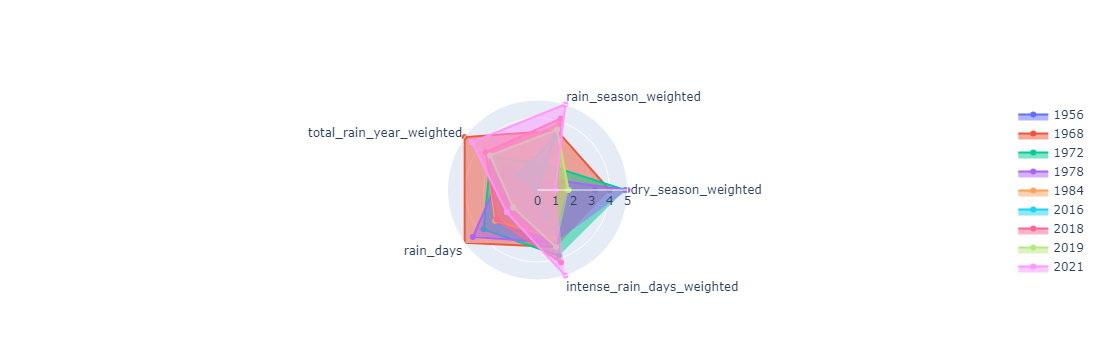

In [22]:
#building the list of categories to be shown on the radar chart
categories = list(climatology_outliers.columns.values)
#building the radar chart
fig = go.Figure()

for years in cocoa_years_outliers:
    fig.add_trace(go.Scatterpolar(
          r=climatology_outliers_scaled.loc[years].tolist(),
          theta=categories,
          fill='toself',
          name=years
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=True
)

fig.show()

In [97]:
#time series clustering
#import the production history
production_history =pd.read_csv ("../raw_data/crop_size.csv")
production_history["calendar_year"] = pd.to_datetime(production_history["calendar_year"], format ="%Y")
production_history["calendar_year"] = production_history["calendar_year"].dt.year
production_history = production_history.set_index(keys = production_history["calendar_year"])
production_history

,calendar_year,crop_year_ending,reported_crop
calendar_year,,,
1949,1949,1950,53
1950,1950,1951,57
1951,1951,1952,45
1952,1952,1953,61
1953,1953,1954,57
...,...,...,...
2025,2025,2026,2070
2026,2026,2027,2035
2027,2027,2028,2000


In [125]:
#creating a new dataframe
cocoa_complete = cocoa_climatology.merge(production_history, left_index = True, right_index = True)
cocoa_complete

,dry_season_weighted,rain_season_weighted,total_rain_year_weighted,rain_days,intense_rain_days_weighted,calendar_year,crop_year_ending,reported_crop
1949,720.000000,573.350006,1293.349976,260.00,1.5000,1949,1950,53
1950,716.250000,643.449982,1359.699951,246.50,1.7500,1950,1951,57
1951,787.949982,693.100006,1481.049988,259.00,2.5000,1951,1952,45
1952,810.149994,798.500000,1608.650024,260.50,2.3750,1952,1953,61
1953,688.050018,696.299988,1384.350037,255.50,2.0000,1953,1954,57
...,...,...,...,...,...,...,...,...
2019,825.725006,1159.824982,1985.549957,264.25,3.5000,2019,2020,2105
2020,848.100006,905.350006,1753.450012,271.00,2.7500,2020,2021,2187
2021,742.400009,1422.575043,2164.975037,271.75,4.3125,2021,2022,2078
2022,837.500000,883.875015,1721.375031,244.50,5.5000,2022,2023,2134


In [126]:
cocoa_complete.corr()

,dry_season_weighted,rain_season_weighted,total_rain_year_weighted,rain_days,intense_rain_days_weighted,calendar_year,crop_year_ending,reported_crop
dry_season_weighted,1.000000,0.132801,0.686717,0.851183,0.438169,-0.279717,-0.279717,-0.300595
rain_season_weighted,0.132801,1.000000,0.811683,0.323079,0.648230,0.463660,0.463660,0.494032
total_rain_year_weighted,0.686717,0.811683,1.000000,0.738570,0.733646,0.175215,0.175215,0.185187
rain_days,0.851183,0.323079,0.738570,1.000000,0.441624,-0.270977,-0.270977,-0.302751
intense_rain_days_weighted,0.438169,0.648230,0.733646,0.441624,1.000000,0.374799,0.374799,0.406979
calendar_year,-0.279717,0.463660,0.175215,-0.270977,0.374799,1.000000,1.000000,0.960330
crop_year_ending,-0.279717,0.463660,0.175215,-0.270977,0.374799,1.000000,1.000000,0.960330
reported_crop,-0.300595,0.494032,0.185187,-0.302751,0.406979,0.960330,0.960330,1.000000


In [110]:
#Using tslearn => not representative
#assembling the two time series in an array for tslearn
#time series which are compared need to be of the same dimension, ie same features
cocoa_weather_crop = to_time_series_dataset([cocoa_complete["total_rain_year_weighted"],cocoa_complete["reported_crop"]])
#normalising the time series
cocoa_weather_crop = TimeSeriesScalerMeanVariance().fit_transform(cocoa_weather_crop)

array([[[-1.00465571],
        [-0.73457653],
        [-0.24061828],
        [ 0.27878075],
        [-0.63423777],
        [-0.98572768],
        [ 0.18414107],
        [-0.08166436],
        [ 0.99926378],
        [-1.15485791],
        [-0.66680196],
        [-1.42615819],
        [-1.37894021],
        [-1.34637602],
        [ 0.17376128],
        [-1.43491029],
        [-0.48790262],
        [-1.18172327],
        [-0.088991  ],
        [ 2.82428319],
        [ 0.61520943],
        [ 0.99702504],
        [ 1.21113451],
        [ 1.77673364],
        [ 0.30238974],
        [ 0.43773442],
        [ 0.03231032],
        [ 0.10496932],
        [-0.12745751],
        [ 1.24899059],
        [ 0.8934299 ],
        [ 1.59132107],
        [ 0.22850963],
        [-0.91998861],
        [-0.90574203],
        [ 1.9751717 ],
        [ 0.17131907],
        [-0.45879803],
        [ 0.41188694],
        [ 1.06011767],
        [-0.01897819],
        [-0.18668358],
        [-0.28803974],
        [-0

In [127]:
# TimeSeriesKMeans with DTW
# Set the number of clusters
n_clusters = 4
#instantiating the model
crop_model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True,metric="dtw")
# training and clustering
y_pred = crop_model.fit_predict(cocoa_complete)
len(y_pred)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


166367.328 --> 118838.543 --> 116362.332 --> 115114.015 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


113390.642 --> 112969.446 --> 109791.037 --> 107186.594 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


102374.773 --> 97739.701 --> 96014.026 --> 95701.073 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


95459.335 --> 95161.184 --> 95161.184 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


75

AttributeError: 'str' object has no attribute 'ravel'

<Figure size 1600x900 with 0 Axes>

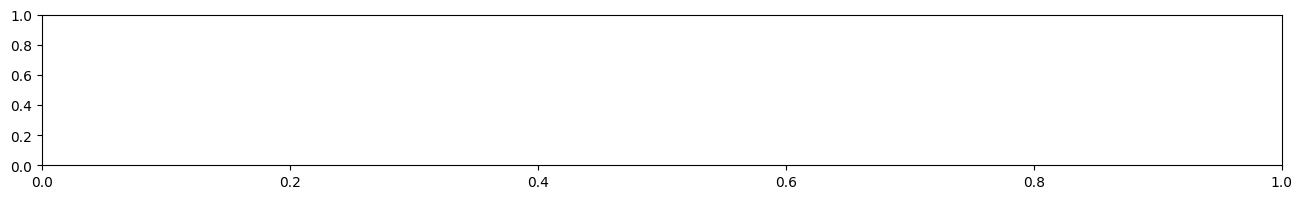

In [128]:
plt.figure(figsize=(16, 9))
# Visualizing the clustering results
plt.figure(figsize=(16, 9))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in cocoa_complete[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(crop_model.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [ ]:
####below are pieces of code used to assemble the functions at the top#######

In [220]:
gps_location = len(actual_weather[0]["date"])
gps_location

30681

In [221]:
len(actual_weather[0]["weather_code"])

30681

In [222]:
weather_point = pd.DataFrame(actual_weather[0])
code_count = weather_point["weather_code"].nunique()
code_list = weather_point["weather_code"].unique().tolist()
code_list

[61.0, 63.0, 53.0, 55.0, 51.0, 3.0, 2.0, 1.0, 0.0, 65.0]

In [92]:
code_dict ={
    0:"no clouds",
    1:"clouds disolving",
    2:"sky unchanged",
    3: "clouds developping",
    61:"rain slight",
    63:"rain moderate",
    65:"rain heavy",
    51:"drizzle, slight",
    53:"drizzle, moderate",
    55:"drizzle, heavy"
}

code_dict.keys()

dict_keys([0, 1, 2, 3, 61, 63, 65, 51, 53, 55])

In [224]:
weather_point['month_number'] = weather_point['date'].dt.month
weather_point['year'] = weather_point['date'].dt.year
weather_point

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,month_number,year
0,1940-01-01,61.0,26.761000,23.061001,24.358917,NaN,NaN,1,1940
1,1940-01-02,63.0,26.611000,22.961000,24.375582,12.0,12.0,1,1940
2,1940-01-03,53.0,26.511000,22.661001,24.177666,1.7,1.7,1,1940
3,1940-01-04,61.0,27.211000,23.611000,24.935999,4.0,4.0,1,1940
4,1940-01-05,55.0,27.211000,24.261000,25.406832,2.5,2.5,1,1940
...,...,...,...,...,...,...,...,...,...
30676,2023-12-27,51.0,31.563000,24.513000,27.708834,1.2,1.2,12,2023
30677,2023-12-28,3.0,32.663002,24.213001,27.583832,0.0,0.0,12,2023
30678,2023-12-29,63.0,31.763000,23.813000,27.169252,4.4,4.4,12,2023
30679,2023-12-30,55.0,31.013000,24.113001,27.125504,3.0,3.0,12,2023


In [384]:
weather_grouped = weather_point.groupby(['year', weather_point['month_number'].isin([5, 6, 7, 8, 9])])['precipitation_sum'].sum().unstack(fill_value=0)
weather_grouped.columns = ['dry_season', 'rain_season']
weather_grouped["total_year_rain"] = weather_grouped["dry_season"] + weather_grouped["rain_season"]
weather_grouped

,dry_season,rain_season,total_year_rain
year,,,
1940,1039.900024,697.100037,1737.000000
1941,952.799988,983.200012,1936.000000
1942,776.700012,495.000000,1271.699951
1943,712.400024,516.200012,1228.600098
1944,777.500000,903.200012,1680.699951
...,...,...,...
2019,809.099976,1091.199951,1900.299927
2020,824.299988,920.799988,1745.099976
2021,695.500000,1376.300049,2071.800049


In [272]:
type(weather_grouped.index)

pandas.core.indexes.base.Index

In [226]:
#average dry season
dry_season_rainfall = weather_grouped["dry_season"][:-30].mean()
dry_season_rainfall

713.88135

In [227]:
#average rain season
rain_season_rainfall = weather_grouped["rain_season"][:-30].mean()
rain_season_rainfall

783.95

In [228]:
monthly_cumul_rain = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({'precipitation_sum': "sum"})
monthly_cumul_rain = monthly_cumul_rain.reset_index()
monthly_cumul_rain

,date,precipitation_sum
0,1940,1565.199951
1,1941,1595.699951
2,1942,946.799988
3,1943,1102.300049
4,1944,1666.400024
...,...,...
79,2019,1798.699951
80,2020,1683.300049
81,2021,2202.899902
82,2022,1615.800049


In [229]:
year = pd.Period(monthly_cumul_rain["date"][83],freq = "Y")
year.year

2023

In [186]:
monthly_cumul_rain["date"][83].year

2023

In [394]:
#yearly_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({'precipitation_sum': lambda x: (x != 0).sum()})
yearly_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({'precipitation_sum': lambda x: (x > 1.0).sum()})


/tmp/ipykernel_95321/4120808980.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  yearly_rain_day.column = ["rain_days"]


In [396]:
yearly_rain_day.index = yearly_rain_day.index.year.astype("int")
yearly_rain_day = yearly_rain_day.rename(columns={"precipitation_sum":"rain_days"})
yearly_rain_day

,rain_days
date,
1940,312
1941,317
1942,264
1943,235
1944,290
...,...
2019,263
2020,270
2021,272


In [342]:
#counting the days with intense rain (ie weather code = 64 or 65
intense_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('Y')).agg({"weather_code": lambda x: (x.isin([64, 65])).sum()})
intense_rain_day.index = intense_rain_day.index.year.astype("int")
intense_rain_day

,weather_code
date,
1940,0
1941,0
1942,0
1943,0
1944,4
...,...
2019,10
2020,6
2021,16


In [343]:
#weather_total = pd.merge(weather_grouped.reset_index(), yearly_rain_day, left_on="year", right_index=True, how='inner')
#weather_total
weather_total = pd.concat([weather_grouped, yearly_rain_day,intense_rain_day], axis=1)
weather_total

,dry_season,rain_season,total_year_rain,precipitation_sum,weather_code
1940,809.199951,756.000000,1565.199951,310,0
1941,644.400024,951.299988,1595.699951,303,0
1942,569.899963,376.899994,946.799927,241,0
1943,553.500000,548.799988,1102.300049,238,0
1944,524.200012,1142.200073,1666.400146,275,4
...,...,...,...,...,...
2019,820.600037,978.099976,1798.699951,287,10
2020,781.200012,902.099976,1683.300049,279,6
2021,721.200012,1481.699951,2202.899902,287,16
2022,775.299988,840.500000,1615.800049,263,16


In [360]:
weather_total["latitude"] = responses[0].Latitude()
weather_total["longitude"] = responses[0].Longitude()
weather_total

,dry_season,rain_season,total_year_rain,precipitation_sum,weather_code,latitude,longitude
1940,809.199951,756.000000,1565.199951,310,0,5.377856,-6.481781
1941,644.400024,951.299988,1595.699951,303,0,5.377856,-6.481781
1942,569.899963,376.899994,946.799927,241,0,5.377856,-6.481781
1943,553.500000,548.799988,1102.300049,238,0,5.377856,-6.481781
1944,524.200012,1142.200073,1666.400146,275,4,5.377856,-6.481781
...,...,...,...,...,...,...,...
2019,820.600037,978.099976,1798.699951,287,10,5.377856,-6.481781
2020,781.200012,902.099976,1683.300049,279,6,5.377856,-6.481781
2021,721.200012,1481.699951,2202.899902,287,16,5.377856,-6.481781
2022,775.299988,840.500000,1615.800049,263,16,5.377856,-6.481781


array([1, 4, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 4, 1, 3, 2, 2, 4, 3, 3, 3, 3,
       3, 1, 3, 1, 3, 1, 0, 2, 2, 2, 2, 4, 4, 2, 1, 1, 2, 4, 2, 4, 3, 3,
       0, 1, 1, 4, 4, 1, 1, 1, 1, 1, 3, 1, 4, 3, 1, 1, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 3, 4, 3, 1, 3, 1, 3, 4, 0, 0, 0, 4, 0, 4, 4], dtype=int32)

84

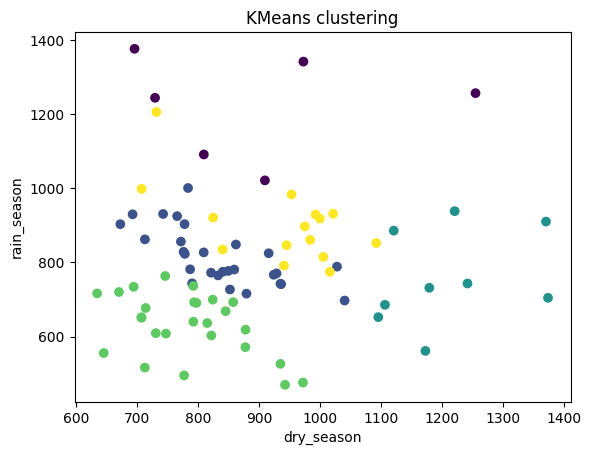

In [415]:
plt.scatter(weather_grouped.iloc[:,0], weather_grouped.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('dry_season'); plt.ylabel('rain_season');

In [287]:
monthly_cumul_rain["date"].dt.year==2023

0     False
1     False
2     False
3     False
4     False
      ...  
79    False
80    False
81    False
82    False
83     True
Name: date, Length: 84, dtype: bool

In [208]:
index_number = monthly_cumul_rain.index.get_loc(monthly_cumul_rain[monthly_cumul_rain["date"].dt.year==1940].index[0])
print(index_number)
print(km.labels_[index_number])
print(

0
4


In [163]:
monthly_min_temp = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'temperature_2m_min': "min"})
monthly_min_temp = monthly_min_temp.reset_index()
monthly_min_temp

,date,temperature_2m_min
0,1940-01,20.386999
1,1940-02,20.636999
2,1940-03,20.937000
3,1940-04,21.487000
4,1940-05,21.136999
...,...,...
1003,2023-08,21.374001
1004,2023-09,21.424002
1005,2023-10,21.724001
1006,2023-11,21.824001


In [97]:
monthly_mean_temp = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'temperature_2m_mean': "mean"})
monthly_mean_temp

,temperature_2m_mean
date,
1940-01,24.107967
1940-02,24.813076
1940-03,25.053936
1940-04,25.159153
1940-05,24.884512
...,...
2023-08,25.007467
2023-09,24.937819
2023-10,25.018490


In [165]:
monthly_avg = monthly_cumul_rain.groupby('date')['precipitation_sum'].mean().reset_index()
monthly_avg

,date,precipitation_sum
0,1940-01,80.200005
1,1940-02,92.599998
2,1940-03,115.400002
3,1940-04,165.100006
4,1940-05,136.800003
...,...,...
1003,2023-08,117.100006
1004,2023-09,229.800003
1005,2023-10,252.500000
1006,2023-11,107.599998


ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of labels (12).

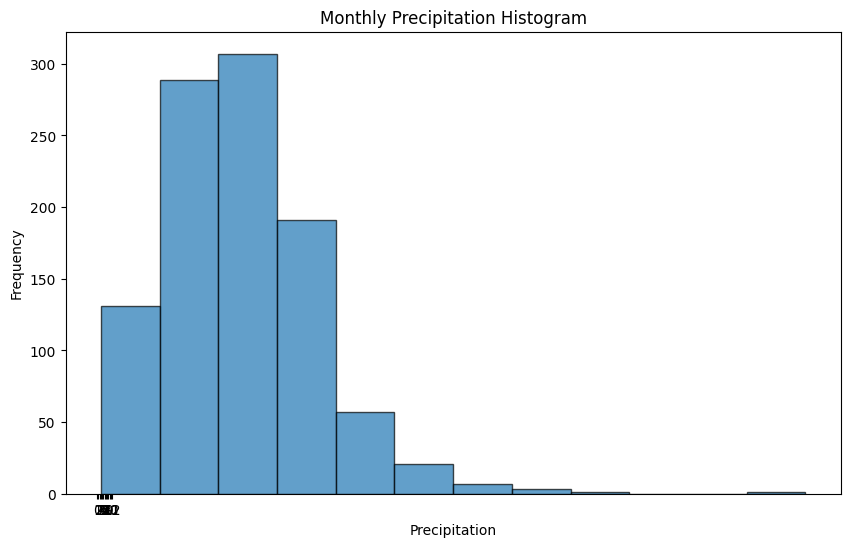

In [117]:
plt.figure(figsize=(10, 6))
plt.hist(monthly_cumul_rain['precipitation_sum'], bins=12, edgecolor='black', alpha=0.7)
plt.title('Monthly Precipitation Histogram')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.xticks(range(13), list(monthly_cumul_rain['month_number'].unique()))  
plt.show()

In [116]:
list(monthly_cumul_rain['month_number'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [104]:
monthly_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'precipitation_sum': lambda x: (x != 0).sum()})
monthly_rain_day = monthly_rain_day.reset_index()
monthly_rain_day

,date,precipitation_sum
0,1940-01,30
1,1940-02,29
2,1940-03,31
3,1940-04,30
4,1940-05,30
...,...,...
1003,2023-08,31
1004,2023-09,30
1005,2023-10,31
1006,2023-11,29
